In [236]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

### Meta Data

In this project, we are predicting the probability that an online transaction is fraudulent, 
as denoted by the binary target isFraud. The data is broken into two files identity and transaction, 
which are joined by TransactionID. Not all transactions have corresponding identity information.

**Transaction Table**

- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: “both addresses are for purchaser; addr1 as billing region; addr2 as billing country”
- **dist: distance**; "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- **P_ and (R__) emaildomain**: purchaser and recipient email domain (certain transactions don't need recipient, so R_emaildomain is null.)
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. (maybe counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.)
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Identity Table**

- **DeviceType**
- **DeviceInfo**
- **id_01 - id_38**
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
- The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement

### Feature Engineering

In this notebook, we will be primarily focused on feature engineering.

Baseline Model:

- Model: XG-Boost

Feature Engineering (important)
- Time
- Day of week (one hot)
- Hour of day (one hot)
- Transaction Amount (take log when linear model?)
- Product Code (one hot)
- Card information
- 4 & 6 (one hot)
- Others : consider later (large amount of categorical data)
- Address
- Top 10 countries and other
- Region: consider later
- Dist
    - Dist1, Dist2 (direct)
- Email_Domain
    - P & R: Top 20 and other
- Count
    - 1-14
- D
    - Consider later
- M1 - M9
    - One hot
- V:
    - Standardized and PCA

龙：
- Device Type & Info:
- One hot
- ID
- IP: feature engineering
    - (If already featured: direct as numeric)
    - (tags < 10): one - hot
    - (tags > 10): consider later


### Load Data

In [147]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
# sample_submission_path = "data/sample_submission.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)
# sample_submission = pd.read_csv(sample_submission_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='left')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]
train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 144233 rows & 434 columns.


In [148]:
train_transaction.shape

(590540, 394)

In [149]:
train_identity.shape

(144233, 41)

In [150]:
test_transaction.shape

(506691, 393)

In [151]:
test_identity.shape

(141907, 41)

In [152]:
# release data from those four
del train_transaction
del train_identity
del test_transaction
del test_identity

### Categorical Data

In [153]:
# Time
# Day of week (one hot)
# Hour of day (one hot)
# Transaction Amount (take log when linear model?)
# Product Code (one hot)
# Card information
# 4 & 6 (one hot)
# Others : consider later (large amount of categorical data)
# Address
# Top 10 countries and other
# Region: consider later
# Dist
# Dist1, Dist2 (direct)
# Email_Domain
# P & R: Top 20 and other
# Count
# 1-14
# D
# Consider later
# M1 - M9
# One hot
# V:
# Standardized and PCA

train_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

In [155]:
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

In [156]:
# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

In [157]:
# Product Code (one hot)
train_df['ProductCD'].value_counts()

C    62192
R    37548
H    32908
S    11585
Name: ProductCD, dtype: int64

In [158]:
# Card information
train_df['card4'].value_counts()

visa                89299
mastercard          44186
american express     8298
discover             2266
Name: card4, dtype: int64

In [159]:
train_df['card6'].value_counts()

credit         75090
debit          68950
charge card       15
Name: card6, dtype: int64

In [160]:
#addr1, addr2
top_ten_addr1 = list(train_df['addr1'].value_counts().index)[:10] #top ten regions
top_ten_addr2 = list(train_df['addr2'].value_counts().index)[:10] #top ten countries

def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)

In [163]:
#Email_Domain
top_twenty_email_p = list(train_df['P_emaildomain'].value_counts().index)[:20] #top ten regions
top_twenty_email_r = list(train_df['R_emaildomain'].value_counts().index)[:20] #top ten countries

train_df['P_emaildomain'].value_counts()
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)

In [164]:
# Count 1-14
train_df['C1'].value_counts()

1.0       104542
2.0        18738
3.0         6055
4.0         3231
5.0         2628
           ...  
1943.0         1
1944.0         1
1945.0         1
1948.0         1
1500.0         1
Name: C1, Length: 1559, dtype: int64

In [165]:
#M1 - M9
train_df['M1'].value_counts()

Series([], Name: M1, dtype: int64)

In [166]:
# V: Standardized and PCA
train_df['V3'].value_counts()

Series([], Name: V3, dtype: int64)

In [167]:
v_data = train_df.iloc[:, 95:434].fillna(0).to_numpy()

In [168]:
# list for one-hot
# one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
#                'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
#                'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new',
#                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
                'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new', 
              'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [172]:
to_ohe = train_df[one_hot_lst]
# try to apply ont hot encoding on the simple categorical features
ohe = OneHotEncoder()
ohe.fit(to_ohe)

OneHotEncoder()

In [176]:
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())
v_data = train_df.iloc[:, 95:434].fillna(0).to_numpy()
# deal with numerical data

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log']
nums_part = train_df[num_list]

In [178]:
v = pd.DataFrame(v_data)
nums = pd.concat([nums_part, v], axis = 1)

In [197]:
# prepare the predicting values
X = pd.concat([nums, cates], axis=1)
y = train_df['isFraud']

In [199]:
xgb_cl = xgb.XGBClassifier()

In [200]:
print(type(xgb_cl))

<class 'xgboost.sklearn.XGBClassifier'>


In [216]:
X.columns = [x for x in range(len(X.columns.tolist()))]

In [240]:
combined_data = pd.concat([X, y], axis=1)

In [241]:
combined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,isFraud
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [251]:
combined_data_0 = combined_data[combined_data['isFraud'] == 0]
combined_data_1 = combined_data[combined_data['isFraud'] == 1]

In [252]:
combined_data_0.shape

(132915, 536)

In [253]:
combined_data_1.shape

(11318, 536)

In [254]:
combined_data_0_10000 = combined_data_0.sample(n=10000, replace=False, ignore_index=True)
combined_data_1_10000 = combined_data_1.sample(n=10000, replace=False, ignore_index=True)

In [262]:
combined_data_10000 = pd.concat([combined_data_0_10000, combined_data_1_10000])

In [263]:
combined_data_10000

,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,isFraud
0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
4,1.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6.0,6.0,0.0,1.0,0.0,4.0,0.0,5.0,0.0,4.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9996,4.0,5.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
9997,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
9998,1.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1


In [264]:
X = combined_data_10000.drop(columns=['isFraud'])
y = combined_data_10000['isFraud']

In [265]:
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: isFraud, Length: 20000, dtype: int64

In [266]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=590540
)

In [267]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,532,533,534
2815,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
190,5.0,6.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2178,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
47,7.0,7.0,0.0,2.0,0.0,3.0,0.0,7.0,0.0,5.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9480,3.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3709,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1840,93.0,122.0,0.0,47.0,0.0,47.0,47.0,66.0,0.0,49.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
8532,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [268]:
# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

[23:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8926

In [269]:
accuracy_score(y_test, preds)

0.8926

In [270]:
preds

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

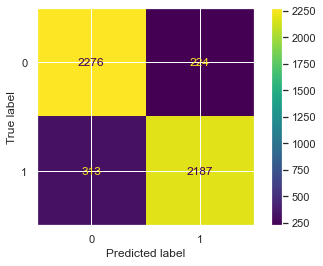

In [278]:
plot_confusion_matrix(xgb_cl, X_test, y_test)

In [279]:
y_preds = xgb_cl.predict_proba(X_test)

In [280]:
preds = y_preds[:,1]

In [281]:
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
auc_score = metrics.auc(fpr, tpr)
plt.clf()

<Figure size 432x288 with 0 Axes>

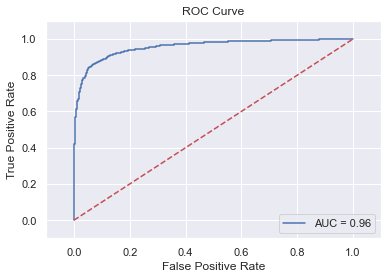

In [282]:
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()